# Intro to Data Validation with Pandera

<a target="_blank" href="https://colab.research.google.com/github/unionai-oss/pandera-workshop/blob/main/workshop.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this workshop, we'll learn how to ensure the integrity and reliability of
your data with Pandera.

We'll cover:
- 🤔 Why Data Quality Matters: Understand common data quality challenges and their impact on data-driven applications.
- ✅ Introduction to Pandera: Explore the core concepts of Pandera, including schema definitions, checks, and validation strategies.
- ⭐️ Hands-on Demo: Build real-world data validation pipelines to catch errors early and improve the reliability of your datasets.
- 🔀 Integrating with Workflows: See how Pandera fits into machine learning pipelines, data engineering workflows, and MLOps environments.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/unionai-oss/pandera-workshop
    %cd pandera-workshop
    !pip install -r requirements.txt

## 🤔 Why Data Quality Matters

Common data quality challenges:

- Data type errors
- Out-of-range values
- Missing values
- Data drift

Can lead to:
- ⏱️ Hours debugging data pipelines
- 📉 Poor model performance
- ❌ Incorrect reporting and decision-making

### Data type errors

A common data type error is when the column is not the correct type. For example,
we might expect a column to be a datetime, but it's actually a string.

In [2]:
import pandas as pd

dates = ["2025-02-01", "2025-02-02", "2025-02-03"]
dates_df = pd.DataFrame({"dates": dates})
dates_df.head()

,dates
0,2025-02-01
1,2025-02-02
2,2025-02-03


So certain operations may fail unexpectedly.

In [3]:
try:
    dates_df - pd.Timestamp("2025-01-01")
except Exception as e:
    print(e)

unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'


### Out-of-range values

Or columns take on values that are logically impossible, for example, an
inventory dataset may contain the price of items, which can't be negative.

In [4]:
prices = [100, 200, 300, -99999]
prices_df = pd.DataFrame({"prices": prices})
prices_df

,prices
0,100
1,200
2,300
3,-99999


Computing the average price of items in the inventory may be confusing or misleading.

In [5]:
prices_df["prices"].mean()

np.float64(-24849.75)

### Missing values

Long and complex data processing pipelines may lead to missing values, maybe
from an incorrectly written SQL query or another bug somewhere in the code:

In [6]:
housing_df = pd.DataFrame({
    "price": [pd.NA, 200000, 300000, 400000, 500000],
    "bedrooms": [pd.NA, 4, 5, 6, 7],
    "bathrooms": [2, 3, 4, 5, 6],
    "sqft": [2000, 3000, 4000, 5000, 6000],
})
housing_df

,price,bedrooms,bathrooms,sqft
0,<NA>,<NA>,2,2000
1,200000,4,3,3000
2,300000,5,4,4000
3,400000,6,5,5000
4,500000,7,6,6000


In some cases this may be expected due to the inherent nature of the data.

However, in cases where missing values are not expected and are due to bugs in
data processing code, we would want to catch these early before the cause issues
during the model training process.

In [7]:
from sklearn.linear_model import LinearRegression

try:
    model = LinearRegression()
    model.fit(housing_df[["bedrooms", "bathrooms", "sqft"]], housing_df["price"])
    model.predict(housing_df[["bedrooms", "bathrooms", "sqft"]])
except Exception as e:
    print(e)


float() argument must be a string or a real number, not 'NAType'


### Data drift

One of the thorniest problems in machine learning is data drift, where the
distribution of the data changes over time, which can cause the relationship
between features and the target to change. This may lead to model degradation
over time.

Below is an example of two normal distributions of some variable from `t1`
drifting to `t2` over time. The `target` is correlated with `data_t1`, but not
with `data_t2`.

<Axes: ylabel='Frequency'>

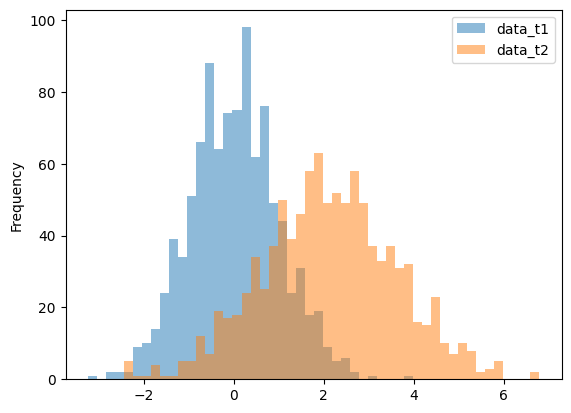

In [8]:
import numpy as np
from scipy import stats

np.random.seed(42)

# Generate two normal distributions with different parameters
n_samples = 1000

data_t1 = stats.norm.rvs(loc=0, scale=1, size=n_samples)
data_t2 = stats.norm.rvs(loc=2, scale=1.5, size=n_samples)

# Create target data that's correlated with data_t1 
# Using a linear relationship with some noise
target = 2 * data_t1 + stats.norm.rvs(loc=0, scale=0.5, size=n_samples)

distributions = pd.DataFrame({
    "data_t1": data_t1,
    "data_t2": data_t2,
    "target": target,
})

distributions[["data_t1", "data_t2"]].plot.hist(bins=50, alpha=0.5)

<Axes: xlabel='data_t2', ylabel='target'>

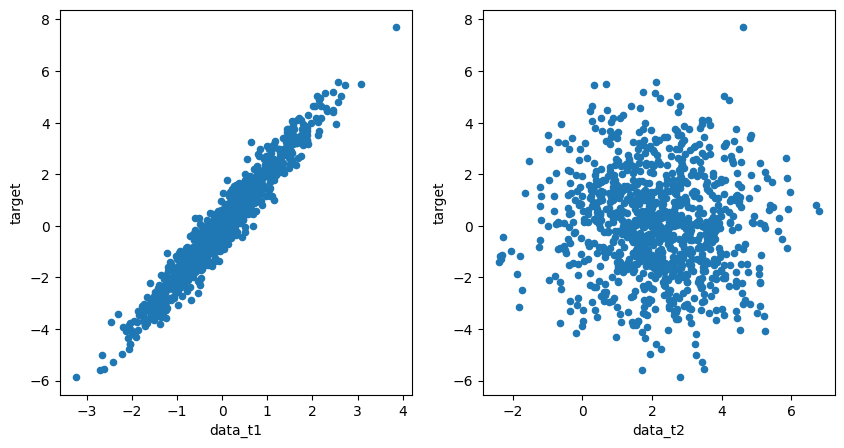

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
distributions[["data_t1", "target"]].plot.scatter(x="data_t1", y="target", ax=ax[0])
distributions[["data_t2", "target"]].plot.scatter(x="data_t2", y="target", ax=ax[1])

## ✅ Introduction to Pandera

Pandera is a tool for validating data in Python. It provides an easy way to
define data validation rules in Python and apply them on data at runtime.

Let's create a schema for the `housing_df` toy dataset that we created earlier:

In [10]:
housing_df

,price,bedrooms,bathrooms,sqft
0,<NA>,<NA>,2,2000
1,200000,4,3,3000
2,300000,5,4,4000
3,400000,6,5,5000
4,500000,7,6,6000


First we create a schema for just the data types of each column:

In [11]:
import pandera as pa

class HousingSchema(pa.DataFrameModel):
    price: float
    bedrooms: int
    bathrooms: float
    sqft: int

But that's not all we can do. We can also add value checks to ensure that the
values are within a certain range of allowed values.

In [12]:
class HousingSchema(pa.DataFrameModel):
    price: float = pa.Field(ge=50_000)
    bedrooms: int = pa.Field(ge=1)
    bathrooms: float = pa.Field(ge=1)
    sqft: int = pa.Field(ge=100)

By default, Pandera assumes that missing values are not allowed.

In [13]:
try:
    HousingSchema.validate(housing_df)
except pa.errors.SchemaError as err:
    print(err)


non-nullable series 'price' contains null values:
0    <NA>
Name: price, dtype: object


We'll have to clean the data to make the validation pass. In this case, let's do
the simple thing and remove rows with missing values.

In [14]:
clean_housing_df = housing_df.dropna()
clean_housing_df

,price,bedrooms,bathrooms,sqft
1,200000,4,3,3000
2,300000,5,4,4000
3,400000,6,5,5000
4,500000,7,6,6000


Finally, we can easily create custom validation checks to check for data drift
or other statistical properties.

In [15]:
class HousingSchemaWithCorrelation(pa.DataFrameModel):
    price: float = pa.Field(ge=50_000)
    bedrooms: int = pa.Field(ge=1)
    bathrooms: float = pa.Field(ge=1)
    sqft: int = pa.Field(ge=100)

    @pa.dataframe_check(error="price and all other features must be positively correlated")
    def check_price_correlation(cls, df: pd.DataFrame) -> bool:
        corr_df = df.corr()
        correlated = corr_df["price"].loc[["bedrooms", "bathrooms", "sqft"]] > 0
        return correlated.all()
    
    class Config:
        coerce = True
    
HousingSchemaWithCorrelation.validate(clean_housing_df)

,price,bedrooms,bathrooms,sqft
1,200000.0,4,3.0,3000
2,300000.0,5,4.0,4000
3,400000.0,6,5.0,5000
4,500000.0,7,6.0,6000


In [16]:
corrupted_housing_df = clean_housing_df.copy()
corrupted_housing_df["bedrooms"] = corrupted_housing_df["bedrooms"].tolist()[::-1]

try:
    HousingSchemaWithCorrelation.validate(corrupted_housing_df)
except pa.errors.SchemaError as err:
    print(err)

DataFrameSchema 'HousingSchemaWithCorrelation' failed series or dataframe validator 0: <Check check_price_correlation: price and all other features must be positively correlated>


## ⭐️ Hands-on Demo

In this demo, we're going to see try to protect against a common machine learning
attack: the label-flipping data poisoning attack.

In this attack, an adversary wants to degrade the performance of an ML model by
flipping the labels in a tabular dataset. If the adversary isn't careful about
how they corrupt the data, we can easily catch this kind of attack against a
reference dataset.

In [17]:
def fetch_heart_disease_data() -> pd.DataFrame:
    heart_disease_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
    return (
        pd.read_csv(heart_disease_data_url, header=None, names=columns)
        .replace({"ca": {"?": None}, "thal": {"?": None}})
        .dropna(subset=["ca", "thal"])
        .astype({"ca": float, "thal": float})
    )

def parse_raw_data(raw_data: pd.DataFrame) -> pd.DataFrame:
    """Convert the target to a binary target."""
    return raw_data.assign(target=lambda _: (_.target > 0).astype(int))


heart_disease_df = parse_raw_data(fetch_heart_disease_data())
heart_disease_df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [18]:
def poison_data(
    df: pd.DataFrame,
    poison_fraction: float = 0.0,
    random_state: int = 0,
) -> pd.DataFrame:
    if poison_fraction <= 0.0:
        return df
    poisoned = df.copy()
    n_poison = int(len(poisoned) * poison_fraction)
    poisoned_indices = poisoned.sample(n=n_poison, random_state=random_state).index
    poisoned.loc[poisoned_indices, 'target'] = 1 - poisoned.loc[poisoned_indices, 'target']
    return poisoned

poisoned_heart_disease_df = poison_data(heart_disease_df, poison_fraction=0.75)
poisoned_heart_disease_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,1


In [19]:
heart_disease_df.target.rename("original target").value_counts().to_frame()

,count
original target,
0,160
1,137


In [20]:
poisoned_heart_disease_df.target.rename("poisoned target").value_counts().to_frame()

,count
poisoned target,
0,152
1,145


The proportions of the target are now different. But are there other ways we
can detect that the data has been poisoned?

In [21]:
from sklearn.ensemble import RandomForestClassifier


def split_data(parsed_data, test_size: float, random_state: int):
    print("splitting data")
    training_set = parsed_data.sample(frac=test_size, random_state=random_state)
    test_set = parsed_data[~parsed_data.index.isin(training_set.index)]
    return training_set, test_set

def get_features_and_target(dataset):
    X = dataset[[x for x in dataset if x != "target"]]
    y = dataset["target"]
    return X, y

def train_model(training_set, random_state: int):
    print("training model")
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    X, y = get_features_and_target(training_set)
    model.fit(X, y)
    return model

def training_pipeline(dataset, test_size: float, random_state: int):
    training_set, test_set = split_data(dataset, test_size, random_state)
    model = train_model(training_set, random_state)
    test_features, test_target = get_features_and_target(test_set)
    acc = (model.predict(test_features) == test_target).mean()
    return model, acc

model, acc = training_pipeline(heart_disease_df, 0.75, 42)
print(f"Test accuracy: {acc:.2f}")


splitting data
training model
Test accuracy: 0.81


In [22]:
model, acc = training_pipeline(poisoned_heart_disease_df, 0.75, 42)
print(f"Test accuracy: {acc:.2f}")

splitting data
training model
Test accuracy: 0.57


The test accuracy of the model trained on the poisoned dataset is now much lower
than the one trained on the original dataset.

Is there a way to detect that the data has been poisoned even before training?

### Creating Pandera DataFrameModels

As we say earlier, `pandera.DataFrameModel` is a way to define a schema
declaratively, in much the same way you could define a dataclass or `pydantic`
model.

Let's create a schema for the raw data that we can use to validate the data
before training.

In [23]:
class RawData(pa.DataFrameModel):
    age: int = pa.Field(in_range={"min_value": 0, "max_value": 200})
    sex: int = pa.Field(isin=[0, 1])
    cp: int = pa.Field(
        isin=[
            1,  # typical angina
            2,  # atypical angina
            3,  # non-anginal pain
            4,  # asymptomatic
        ]
    )
    trestbps: int = pa.Field(in_range={"min_value": 0, "max_value": 200})
    chol: int = pa.Field(in_range={"min_value": 0, "max_value": 600})
    fbs: int = pa.Field(isin=[0, 1])
    restecg: int = pa.Field(
        isin=[
            0,  # normal
            1,  # having ST-T wave abnormality
            2,  # showing probable or definite left ventricular hypertrophy by Estes' criteria
        ]
    )
    thalach: int = pa.Field(in_range={"min_value": 0, "max_value": 300})
    exang: int = pa.Field(isin=[0, 1])
    oldpeak: float = pa.Field(in_range={"min_value": 0, "max_value": 10})
    slope: int = pa.Field(
        isin=[
            1,  # upsloping
            2,  # flat
            3,  # downsloping
        ]
    )
    ca: int = pa.Field(isin=[0, 1, 2, 3])
    thal: int = pa.Field(
        isin=[
            3,  # normal
            6,  # fixed defect
            7,  # reversible defect
        ]
    )
    target: int = pa.Field(ge=0, le=4)

    class Config:
        coerce = True

We can inherit from `RawData` to create a schema for the parsed data to make
sure that we've binarized the `target` column.

In [24]:
class ParsedData(RawData):
    target: int = pa.Field(isin=[0, 1])

Finally, we create a `TrainingData` model to validate the statistical properties
of the data.

In [69]:
class TrainingData(ParsedData):
    @pa.dataframe_check(error="Patients with heart disease should have higher average cholesterol")
    def validate_cholesterol(cls, df: pd.DataFrame) -> bool:
        healthy_chol = df[df.target == 0].chol.mean()
        disease_chol = df[df.target == 1].chol.mean()
        return disease_chol > healthy_chol

    @pa.dataframe_check(error="Patients with heart disease should not have lower max heart rate (thalach) on average")
    def validate_max_heart_rate(cls, df: pd.DataFrame) -> bool:
        healthy_thalach = df[df.target == 0].thalach.mean()
        disease_thalach = df[df.target == 1].thalach.mean()
        return disease_thalach < healthy_thalach

    @pa.dataframe_check(error="Exercise-induced angina is not more common in disease group")
    def validate_exercise_induced_angina(cls, df: pd.DataFrame) -> bool:
        exang_ratio = df[df.target == 1].exang.mean() / df[df.target == 0].exang.mean()
        return exang_ratio > 2.0

    @pa.dataframe_check(error="cp, exang, and oldpeak should be positively correlated with target")
    def validate_feature_correlations(cls, df: pd.DataFrame) -> bool:
        """Ensure key feature correlations with target remain strong"""
        corrs = df.corr()['target']
        return all(corrs[['cp', 'exang', 'oldpeak']] > 0.2)  # These should be strongly correlated

In [70]:
TrainingData.validate(heart_disease_df).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [71]:
try:
    TrainingData.validate(poisoned_heart_disease_df, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err)


{
    "DATA": {
        "DATAFRAME_CHECK": [
            {
                "schema": "TrainingData",
                "column": "TrainingData",
                "check": "Patients with heart disease should have higher average cholesterol",
                "error": "DataFrameSchema 'TrainingData' failed series or dataframe validator 0: <Check validate_cholesterol: Patients with heart disease should have higher average cholesterol>"
            },
            {
                "schema": "TrainingData",
                "column": "TrainingData",
                "check": "Patients with heart disease should not have lower max heart rate (thalach) on average",
                "error": "DataFrameSchema 'TrainingData' failed series or dataframe validator 1: <Check validate_max_heart_rate: Patients with heart disease should not have lower max heart rate (thalach) on average>"
            },
            {
                "schema": "TrainingData",
                "column": "TrainingData",
          

Now let's refactor our pipeline to use the `DataFrameModel`s throughout so
we validate the data at runtime.

In [89]:
import typing
from sklearn.ensemble import RandomForestClassifier
from pandera.typing import DataFrame


DataSplits = typing.NamedTuple(
    "DataSplits",
    training_set=DataFrame[ParsedData],
    test_set=DataFrame[ParsedData],
)


@pa.check_types(lazy=True)
def parse_raw_data(raw_data: DataFrame[RawData]) -> DataFrame[ParsedData]:
    """Convert the target to a binary target."""
    print("parsing raw data")
    return raw_data.assign(target=lambda _: (_.target > 0).astype(int))

@pa.check_types(lazy=True)
def split_data(
    parsed_data: DataFrame[ParsedData],
    test_size: float,
    random_state: int,
) -> DataSplits:
    print("splitting data")
    training_set = parsed_data.sample(frac=test_size, random_state=random_state)
    test_set = parsed_data[~parsed_data.index.isin(training_set.index)]
    return training_set, test_set

def get_features_and_target(dataset):
    X = dataset[[x for x in dataset if x != "target"]]
    y = dataset["target"]
    return X, y

@pa.check_types(lazy=True)
def train_model(training_set: DataFrame[TrainingData], random_state: int):
    print("training model")
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)
    X, y = get_features_and_target(training_set)
    model.fit(X, y)
    return model

def evaluate_model(model, test_set):
    test_features, test_target = get_features_and_target(test_set)
    acc = (model.predict(test_features) == test_target).mean()
    return acc

def training_pipeline(dataset, test_size: float=0.2, random_state: int = 100):
    parsed_data = parse_raw_data(dataset)
    training_set, test_set = split_data(parsed_data, test_size, random_state)
    model = train_model(training_set, random_state)
    acc = evaluate_model(model, test_set)
    return model, acc

Let's run the pipeline on the original dataset:

In [90]:
model, acc = training_pipeline(heart_disease_df)
print(f"Test accuracy: {acc:.2f}")

parsing raw data
splitting data
training model
Test accuracy: 0.79


And now let's run the pipeline on the poisoned dataset:

In [91]:
try:
    training_pipeline(poisoned_heart_disease_df)
except pa.errors.SchemaErrors as err:
    print(err)


parsing raw data
splitting data
{
    "DATA": {
        "DATAFRAME_CHECK": [
            {
                "schema": "TrainingData",
                "column": "TrainingData",
                "check": "Patients with heart disease should not have lower max heart rate (thalach) on average",
                "error": "DataFrameSchema 'TrainingData' failed series or dataframe validator 1: <Check validate_max_heart_rate: Patients with heart disease should not have lower max heart rate (thalach) on average>"
            },
            {
                "schema": "TrainingData",
                "column": "TrainingData",
                "check": "Exercise-induced angina is not more common in disease group",
                "error": "DataFrameSchema 'TrainingData' failed series or dataframe validator 2: <Check validate_exercise_induced_angina: Exercise-induced angina is not more common in disease group>"
            },
            {
                "schema": "TrainingData",
                "colum

## 🔀 Integrating with Workflows

In this final section, we'll see how Pandera can be integrated into a machine
learning orchestrator.

Let's adapt the label-flipping attack demo to a Union workflow, see how
we can catch the attack early, and visualize the error report on the Union UI.

Take a look at the [`workflow.py`](./workflow.py) file in this repository to see how we can convert
the python functions above into a production-ready Union workflow.

Let's write the datasetes out into a parquet file:

In [92]:
heart_disease_df.to_parquet("heart_disease_df.parquet")
poisoned_heart_disease_df.to_parquet("poisoned_heart_disease_df.parquet")

We can use the `union` CLI to run the workflow:

In [95]:
!union run --remote workflow.py training_pipeline --dataset heart_disease_df.parquet

Running Execution on Remote.
Image pandera-workshop:JVgq9rMaAmPBKcoedGxynA found. Skip building.
0:00:00 Running execution on remote.
[✔] Go to https://serverless.union.ai/org/cosmicbboy/projects/default/domains/development/executions/acl5ncnj45b5t6zlfvmd to see execution in the console.
0:00:00 Running execution on remote.


Now let's run in with the poisoned dataset:

In [96]:
!union run --remote workflow.py training_pipeline --dataset poisoned_heart_disease_df.parquet

Running Execution on Remote.
Image pandera-workshop:JVgq9rMaAmPBKcoedGxynA found. Skip building.
0:00:00 Running execution on remote.
[✔] Go to https://serverless.union.ai/org/cosmicbboy/projects/default/domains/development/executions/alf8vpgjt88xvglgnwx8 to see execution in the console.
0:00:00 Running execution on remote.


You should see a `Deck` that visualizes the Panderavalidations that passed and failed.

🎉 Congrats! You've learned how to use Pandera to validate data at runtime and
and integrate it with a machine learning orchestrator to catch data errors and
bugs as early as possible so that you can:

- Spend less time trying to find where data errors were introduced.
- Spend more time focusing on improving your model and data products.

To learn more about Union, data validation, and building AI pipelines:

- Check out the [Pandera Documentation](https://pandera.readthedocs.io/en/latest/).
- Check out the [Union Documentation](https://docs.union.ai/serverless/user-guide/).
- Contact us at [Union.ai](https://www.union.ai/contact) for a demo or to learn more about Union Enterprise.
- Join our [Slack community](https://join.slack.com/t/flyte-org/shared_invite/zt-1citnqimc-A8NuS9b0qFiqn_yrRCaxtQ) to ask questions and share your projects with other Union users.
